In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    E = 0
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
    else:
        y_value = y
        y_error = [0]*len(y_value)
    plt.grid(True)
    plt.plot(x_value, y_value, "o")
    k, b = mnk_non_zero(x, y)
    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)

    k *= 10**E
    k.E = E
    b *= 10**E
    b.E = E
    
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    E = 0
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
        E -= x[0].E
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
        E += y[0].E
    else:
        y_value = y
        y_error = [0]*len(y_error)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x_value.min()
    if(xmax == None):
        xmax = x_value.max()
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)

    print("k, b =", k, b)
    k *= 10**E
    k.E = E
    b *= 10**E
    b.E = E
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str[:10]} \pm {delta_str[:10]}$"
            elif not E or self.E == 0:

                return (f"{value_str[:10]} \pm {delta_str[:10]}")
            else:
                return (f"{value_str[:10]} \pm {delta_str[:10]} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



<>:230: SyntaxWarning: invalid escape sequence '\p'
<>:233: SyntaxWarning: invalid escape sequence '\p'
<>:235: SyntaxWarning: invalid escape sequence '\p'
<>:235: SyntaxWarning: invalid escape sequence '\c'
<>:238: SyntaxWarning: invalid escape sequence '\p'
<>:230: SyntaxWarning: invalid escape sequence '\p'
<>:233: SyntaxWarning: invalid escape sequence '\p'
<>:235: SyntaxWarning: invalid escape sequence '\p'
<>:235: SyntaxWarning: invalid escape sequence '\c'
<>:238: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_15520\962902864.py:230: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str[:10]} \pm {delta_str[:10]}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_15520\962902864.py:233: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str[:10]} \pm {delta_str[:10]}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_15520\962902864.py:235: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str[:10]} \p

In [68]:
L = DData(100.7, 0.5, E=-3)
RL = DData(43, 5)
CV = pd.DataFrame()
CV["$C_{уст}$, nF"] = [0,2,4,6,8]
CV["$\\nu$, KHz"] = [15.24, 9.091, 7.042, 5.952, 5.263]
CV["$C_{уст}$, nF"] = CV["$C_{уст}$, nF"].apply(lambda x: DData(x, 0.01, E = -9))
CV["$\\nu$, KHz"] = CV["$\\nu$, KHz"].apply(lambda x: DData(x, 0.001, E = 3))
c0 = 1/(2*3.1419*CV["$\\nu$, KHz"][0])**2/L
c0.E = -9
print(c0)
CV["$C_{факт}$, nF"] = CV["$C_{уст}$, nF"]+c0
CV["$T_{эксп}$, мкс"] = 1/CV["$\\nu$, KHz"]
CV["$T_{теор}$, мкс"] = (CV["$C_{факт}$, nF"]*L)**0.5 * 2*3.142

DData.changeEInSerias(CV["$T_{эксп}$, мкс"], -6)
CV

$1.0828 \pm 0.0054$


,"$C_{уст}$, nF","$\nu$, KHz","$C_{факт}$, nF","$T_{эксп}$, мкс","$T_{теор}$, мкс"
0,$0.000 \pm 0.010$,$15.2400 \pm 0.0010$,$1.083 \pm 0.011$,$65.6168 \pm 0.0043$,$65.62 \pm 0.38$
1,$2.000 \pm 0.010$,$9.0910 \pm 0.0010$,$3.083 \pm 0.011$,$109.999 \pm 0.012$,$110.72 \pm 0.34$
2,$4.000 \pm 0.010$,$7.0420 \pm 0.0010$,$5.083 \pm 0.011$,$142.005 \pm 0.020$,$142.17 \pm 0.39$
3,$6.000 \pm 0.010$,$5.9520 \pm 0.0010$,$7.083 \pm 0.011$,$168.011 \pm 0.028$,$167.82 \pm 0.44$
4,$8.000 \pm 0.010$,$5.2630 \pm 0.0010$,$9.083 \pm 0.011$,$190.006 \pm 0.036$,$190.05 \pm 0.49$


In [69]:
CV.to_clipboard()

[ 53.17606516 202.48991934]
k, b = $1.0021 \pm 0.0039$ $-0.44 \pm 0.55$


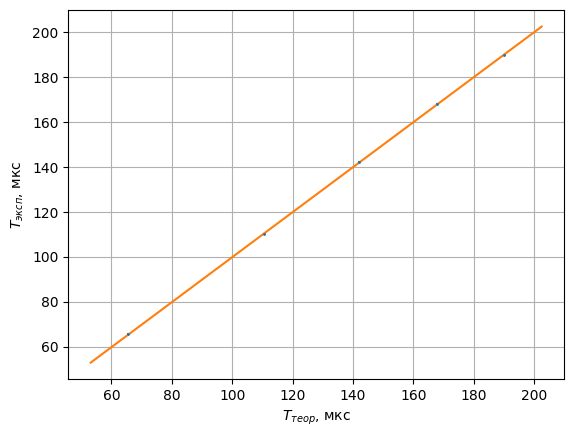

In [70]:
plt.xlabel("$T_{теор}$, мкс")
plt.ylabel("$T_{эксп}$, мкс")
linearcalc_error(CV["$T_{теор}$, мкс"], CV["$T_{эксп}$, мкс"])
plt.savefig("TT.jpg", dpi = 300)

In [71]:
C = DData(5,0.1,E=-9)+c0
v = 1/(L*C)**0.5/2/3.142
v.E = 0

In [72]:
RAN = pd.DataFrame()
RAN["R, Ом"] = [320,370,420,470,700,900,1500,1200]
RAN["A1, мВ"] = [772,678,604,534,1050,920,586,732]
RAN["A2, мВ"] = [242,180,132,102,96,52,46,32]
RAN["R, Ом"] = RAN["R, Ом"].apply(lambda x: DData(x, 1))

RAN["n"] = [5,5,5,5,5,5,3,4]
RAN["n"] = RAN["n"]-1
RAN["$R_{\\Sigma}$"] = RAN["R, Ом"] + RL
RAN["$\\theta$"] = 1/RAN["n"] * np.log(RAN["A1, мВ"]/RAN["A2, мВ"]).apply(lambda x: DData(x, epsilon=0.01))
RAN["A1, мВ"] = RAN["A1, мВ"].apply(lambda x: DData(x, 1, E =-3))
RAN["A2, мВ"] = RAN["A2, мВ"].apply(lambda x: DData(x, 1, E =-3))
RAN["Q"] = 3.142/RAN["$\\theta$"]
RAN["$Q_{теор}$"] = 1/RAN["$R_{\\Sigma}$"]*(L/C)**0.5
DData.changeEInSerias(RAN["$Q_{теор}$"], 0)
RAN

,"R, Ом","A1, мВ","A2, мВ",n,$R_{\Sigma}$,$\theta$,Q,$Q_{теор}$
0,$320.0 \pm 1.0$,$772.0 \pm 1.0$,$242.0 \pm 1.0$,4,$363.0 \pm 5.1$,$0.2900 \pm 0.0029$,$10.83 \pm 0.11$,$11.21 \pm 0.18$
1,$370.0 \pm 1.0$,$678.0 \pm 1.0$,$180.0 \pm 1.0$,4,$413.0 \pm 5.1$,$0.3315 \pm 0.0033$,$9.477 \pm 0.095$,$9.85 \pm 0.15$
2,$420.0 \pm 1.0$,$604.0 \pm 1.0$,$132.0 \pm 1.0$,4,$463.0 \pm 5.1$,$0.3802 \pm 0.0038$,$8.264 \pm 0.083$,$8.79 \pm 0.12$
3,$470.0 \pm 1.0$,$534.0 \pm 1.0$,$102.0 \pm 1.0$,4,$513.0 \pm 5.1$,$0.4139 \pm 0.0041$,$7.592 \pm 0.076$,$7.93 \pm 0.10$
4,$700.0 \pm 1.0$,$1050.0 \pm 1.0$,$96.0 \pm 1.0$,4,$743.0 \pm 5.1$,$0.5980 \pm 0.0060$,$5.254 \pm 0.053$,$5.476 \pm 0.060$
5,$900.0 \pm 1.0$,$920.0 \pm 1.0$,$52.0 \pm 1.0$,4,$943.0 \pm 5.1$,$0.7183 \pm 0.0072$,$4.374 \pm 0.044$,$4.315 \pm 0.044$
6,$1500.0 \pm 1.0$,$586.0 \pm 1.0$,$46.0 \pm 1.0$,2,$1543.0 \pm 5.1$,$1.272 \pm 0.013$,$2.469 \pm 0.025$,$2.637 \pm 0.024$
7,$1200.0 \pm 1.0$,$732.0 \pm 1.0$,$32.0 \pm 1.0$,3,$1243.0 \pm 5.1$,$1.043 \pm 0.010$,$3.011 \pm 0.030$,$3.273 \pm 0.031$


In [73]:
RAN.to_clipboard()

[-2.96883778e-07  8.30594041e-06]
k, b = $1550000.0 \pm 23000.0$ $-0.022 \pm 0.095$
$7820 \pm 59$ $6430 \pm 55$ $8.138 \pm 0.070$


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_15520\962902864.py:237: UserWarning: Что-то сломалось при отображении 
  warnings.warn("Что-то сломалось при отображении ")


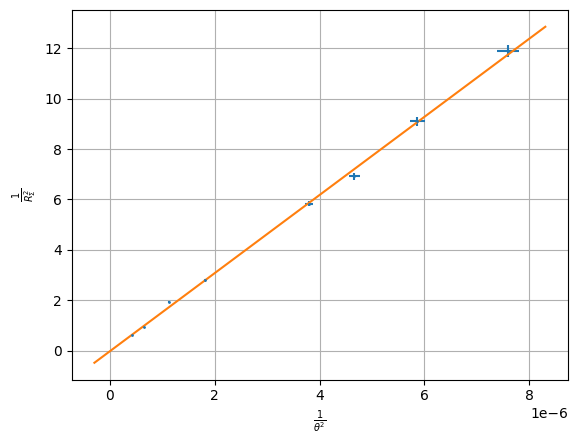

In [74]:


plt.xlabel("$\\frac{1}{\\theta^2}$")
plt.ylabel("$\\frac{1}{R_{\\Sigma}^2}$")
k, _ = linearcalc_error(1/RAN["$R_{\\Sigma}$"]**2, 1/RAN["$\\theta$"]**2)
R_cr = 2*3.14*k**0.5
print(R_cr, v, 2*(L/C)**0.5)
plt.savefig("RTH.png", dpi=300)

$2.86 \pm 0.24$ $9.1 \pm 1.7$


,"v, кГц","A, В","x, мкс","w, 1/c",$\delta \phi$
0,5.8,4.7,99.6,36447.2,0.48814
1,5.9,5.5,99.6,37075.6,0.55073
2,6.0,6.6,99.6,37704.0,0.61332
3,6.1,7.8,103.0,38332.4,0.80624
4,6.2,9.3,105.0,38960.8,0.94888
5,6.3,11.0,110.0,39589.2,1.21281
6,6.4,12.4,116.0,40217.6,1.52324
7,6.5,12.4,122.0,40846.0,1.84121
8,6.6,11.4,127.0,41474.4,2.12525
9,6.7,10.0,130.0,42102.8,2.33136


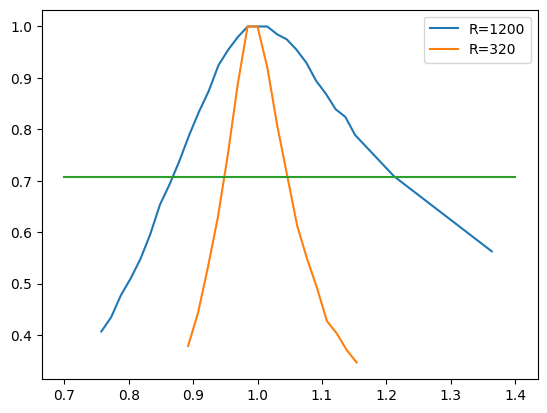

In [75]:
vA = pd.DataFrame()
vA["v, кГц"] = [5,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,9.0,10.0]
vA["A,В"] = [1.62,1.73,1.90,2.03,2.18,2.37,2.60,2.76,2.94,3.14,3.32,3.48,3.68,3.80,3.90,3.98,3.98,3.98,3.92,3.88,3.80,3.70,3.56,3.46,3.34,3.28,3.14,3.06,2.98,2.90,2.82,2.24,1.94]
vB = pd.DataFrame()
vB["v, кГц"] = [5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5]
vB["A, В"] = [4.7,5.5,6.6,7.8,9.3,11.0,12.4,12.4,11.4,10.0,8.8,7.6,6.8,6.1,5.3,5,4.6,4.3]
vB["x, мкс"] = [99.6,99.6,99.6,103,105,110,116,122,127,130,132,133,133,133,132,131,130,128]
vB["w, 1/c"] = vB["v, кГц"]*2*3142
vB["$\\delta \\phi$"] = vB["x, мкс"]*vB["v, кГц"]*2*3.142/1000-3.142

vB["w, 1/c"] = vB["w, 1/c"].apply(lambda x: round(x, 5))
vB["$\\delta \\phi$"] = vB["$\\delta \\phi$"].apply(lambda x: round(x, 5))
plt.plot(vA["v, кГц"][:32]/6.6, vA["A,В"][:32]/3.98, label = "R=1200")
plt.plot(vB["v, кГц"]/6.5, vB["A, В"]/12.4, label = "R=320")
plt.plot([0.7,1.4],[1/2**0.5, 1/2**0.5])
plt.legend()
SH1 = DData(1.2-0.85, 0.03)
SH2 = DData(1.05-0.94, 0.02)
Q1 = 1/SH1
Q2 = 1/SH2
print(Q1, Q2)
plt.savefig("DOBR.png", dpi = 300)
vB


In [76]:
vA.to_clipboard()

In [77]:
vB.to_clipboard()

$10.9 \pm 1.8$


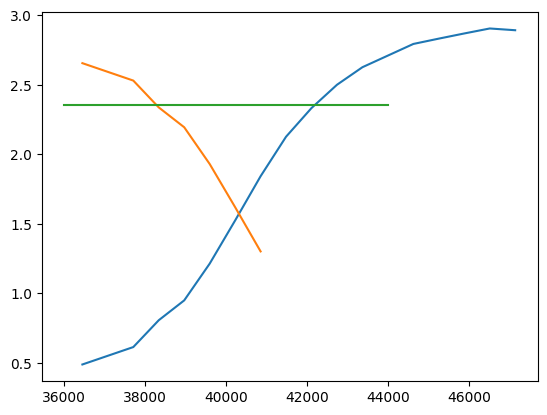

In [78]:
plt.plot(vB["w, 1/c"], vB["$\\delta \\phi$"])
plt.plot(vB["w, 1/c"][vB["$\\delta \\phi$"]<2], 3.142-vB["$\\delta \\phi$"][vB["$\\delta \\phi$"]<2])
plt.plot([36000, 44000], [3.142*3/4, 3.142*3/4])
dW = DData(42300- 38600, 600)
w0 = DData(40300, 30)
Q = w0/dW
print(Q)
plt.savefig("fch.png",dpi=300)

In [79]:
U0 = DData(12.5)
def calc(U0, U1, U2, n):
    x = U0-U1
    y = U0-U2
    return 1/n * DData(np.log(x/y), epsilon=(0.08/x + 0.08/y))
def calc_zat(U1, U2, n):
    x = U1
    y = U2
    return 1/n * DData(np.log(x/y), epsilon=(0.08/x + 0.08/y))
print(3.14/calc(12.5,5.6,9.7,3))
print(3.14/calc_zat(6.8,2.84,3))
print(3.14/calc(9.04,3.32,6.44,2))
print(3.14/calc_zat(6,1.8,3))

$10.44 \pm 0.42$
$10.79 \pm 0.43$
$7.96 \pm 0.36$
$7.82 \pm 0.45$


In [80]:
VOZ_320 = pd.DataFrame()
VOZ_320["$U_0$, В"] = [12.5, 12.5, 12.5, 12.5]
VOZ_320["$U_1$, В"] = [5.6, 7.52, 8.68, 3.48]
VOZ_320["$U_2$, В"] = [9.7, 10.32, 10.84, 8.76]
VOZ_320["n"] = [3,3,3,3]
rez=[]
for i in range(4):
    rez.append(calc(VOZ_320["$U_0$, В"][i], VOZ_320["$U_1$, В"][i],VOZ_320["$U_2$, В"][i],VOZ_320["n"][i]))

VOZ_320["$\\theta$"] = rez
VOZ_320["Q"] = 3.142/VOZ_320["$\\theta$"]
VOZ_320

,"$U_0$, В","$U_1$, В","$U_2$, В",n,$\theta$,Q
0,12.5,5.60,9.70,3,$0.301 \pm 0.012$,$10.45 \pm 0.42$
1,12.5,7.52,10.32,3,$0.275 \pm 0.015$,$11.41 \pm 0.60$
2,12.5,8.68,10.84,3,$0.278 \pm 0.019$,$11.31 \pm 0.78$
3,12.5,3.48,8.76,3,$0.2935 \pm 0.0089$,$10.71 \pm 0.32$


In [81]:
VOZ_470 = pd.DataFrame()
VOZ_470["$U_0$, В"] = [9.04, 9.04, 9.04, 9.04]
VOZ_470["$U_1$, В"] = [3.32, 5.2, 3.32, 0.96]
VOZ_470["$U_2$, В"] = [6.44, 7.28, 7.28, 5.24]
VOZ_470["n"] = [2,2,3,2]
rez=[]
for i in range(4):
    rez.append(calc(VOZ_470["$U_0$, В"][i], VOZ_470["$U_1$, В"][i],VOZ_470["$U_2$, В"][i],VOZ_470["n"][i]))

VOZ_470["$\\theta$"] = rez
VOZ_470["Q"] = 3.142/VOZ_470["$\\theta$"]
VOZ_470

,"$U_0$, В","$U_1$, В","$U_2$, В",n,$\theta$,Q
0,9.04,3.32,6.44,2,$0.394 \pm 0.018$,$7.97 \pm 0.36$
1,9.04,5.20,7.28,2,$0.390 \pm 0.026$,$8.05 \pm 0.53$
2,9.04,3.32,7.28,3,$0.393 \pm 0.023$,$8.00 \pm 0.48$
3,9.04,0.96,5.24,2,$0.377 \pm 0.012$,$8.33 \pm 0.26$


In [93]:
UTH_320 = pd.DataFrame()
UTH_320["$U_1$, В"] = [6.8,5.08,3.84]
UTH_320["$U_2$, В"] = [2.84,2.12,1.60]
UTH_320["n"] = [3,3,3]
rez=[]
for i in range(3):
    rez.append(calc_zat(UTH_320["$U_1$, В"][i],UTH_320["$U_2$, В"][i],UTH_320["n"][i]))
UTH_320["$\\theta$"] = rez
UTH_320["Q"] = 3.142/UTH_320["$\\theta$"]
UTH_320

,"$U_1$, В","$U_2$, В",n,$\theta$,Q
0,6.80,2.84,3,$0.291 \pm 0.012$,$10.80 \pm 0.43$
1,5.08,2.12,3,$0.291 \pm 0.016$,$10.79 \pm 0.58$
2,3.84,1.60,3,$0.292 \pm 0.021$,$10.77 \pm 0.76$


In [94]:
UTH_470 = pd.DataFrame()
UTH_470["$U_1$, В"] = [6,6,4,6]
UTH_470["$U_2$, В"] = [4,2.72,1.84,1.8]
UTH_470["n"] = [1,2,2,3]
rez=[]
for i in range(4):
    rez.append(calc_zat(UTH_470["$U_1$, В"][i],UTH_470["$U_2$, В"][i],UTH_470["n"][i]))
UTH_470["$\\theta$"] = rez
UTH_470["Q"] = 3.142/UTH_470["$\\theta$"]
UTH_470

,"$U_1$, В","$U_2$, В",n,$\theta$,Q
0,6,4.00,1,$0.405 \pm 0.014$,$7.75 \pm 0.26$
1,6,2.72,2,$0.396 \pm 0.017$,$7.94 \pm 0.34$
2,4,1.84,2,$0.388 \pm 0.025$,$8.09 \pm 0.51$
3,6,1.80,3,$0.401 \pm 0.023$,$7.83 \pm 0.45$


In [96]:
VOZ_320.to_clipboard()

In [97]:
VOZ_470.to_clipboard()

In [98]:
UTH_320.to_clipboard()

In [99]:
UTH_470.to_clipboard()

In [95]:
VOZ_320_Q = SerDData(VOZ_320["Q"]).mean
VOZ_470_Q = SerDData(VOZ_470["Q"]).mean
UTH_320_Q = SerDData(UTH_320["Q"]).mean
UTH_470_Q = SerDData(UTH_470["Q"]).mean

print(VOZ_320_Q, VOZ_470_Q, UTH_320_Q, UTH_470_Q)

$10.97 \pm 0.57$ $8.09 \pm 0.42$ $10.78 \pm 0.61$ $7.90 \pm 0.40$
